In [1]:
!pip install transformers 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 70.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.6 MB/s eta 0:00:00


In [2]:
!pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.0 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=62411b335aad8f276fc048af1ff788a5224d998b5f43748125946773b0acd4fa
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


## Imports




In [3]:
import numpy as np
import pandas as pd

import torch
import transformers
from transformers import BertModel, BertTokenizerFast
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics.pairwise import cosine_similarity

## Reading the Dataset 
The below top_actor dataset consist of the top 88 protagonist and their movies

In [4]:
main_df = pd.read_csv("/content/top_actorInput.csv")
main_df.head()

,Unnamed: 0,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,plot,actor
0,0,tt10023022,Clean,Clean,2021,94,"Action,Crime,Drama",5.6,9484.0,"Clean is a garbage man, attempting a quiet lif...",Adrien Brody
1,1,tt10059518,Unhinged,Unhinged,2020,90,"Action,Thriller",6.0,71456.0,Academy Award winner Russell Crowe stars in Un...,Russell Crowe
2,2,tt1013743,Knight and Day,Knight and Day,2010,109,"Action,Adventure,Comedy",6.3,201291.0,Looking forward to attending her sister April'...,Tom Cruise
3,3,tt10228134,Jolt,Jolt,2021,91,"Action,Comedy,Crime",5.6,32967.0,A bouncer with a slightly murderous anger-mana...,Stanley Tucci
4,4,tt1025100,Gemini Man,Gemini Man,2019,117,"Action,Sci-Fi,Thriller",5.7,116259.0,"Retiring assassin, Henry Brogan finds himself ...",Will Smith


## Dropping Unneccesary Data Columns
To recommend the protagonist of the movie we will be using title, genre, imdb rating and plot of the movie for our analysis

In [5]:
# df is the filtered dataset
df = pd.DataFrame()
df["title"] = main_df["primaryTitle"]
df["genres"] = main_df["genres"]
df["plot"] = main_df["plot"]
df["imdb"] = main_df["averageRating"]
df['actor'] = main_df['actor']

df.head()
print("Shape of the dataframe df: ", df.shape)

Shape of the dataframe df:  (1825, 5)


## Preprocessing and Data-Analysis



Dropping the rows with NAN values

In [6]:
df.isna().sum()

title      0
genres     0
plot       1
imdb      43
actor     61
dtype: int64

In [7]:
# as title, genre, imdb, plot, are the required for recommendation we will drop the rows containing NAN values in the either column
df = df.replace({'NaN': np.nan})
df = df.dropna(subset=['plot', 'actor', 'genres', 'title', 'imdb'], axis=0, how='any')
print("New shape of the dataframe df: ", df.shape)

New shape of the dataframe df:  (1727, 5)


Making the name of actor a single string as required to get the actor embedding in the future

In [8]:
df["actor"] = df["actor"].apply(lambda name: "".join(name.split()))
print(df["actor"].values)

['AdrienBrody' 'RussellCrowe' 'TomCruise' ... 'J.K.Simmons' 'BruceWillis'
 'J.K.Simmons']


Check and Remove any duplicate rows

In [9]:
print("Duplicate Rows : ", df.duplicated().sum())
df.drop(axis="rows", labels=df.index[df.duplicated()], inplace=True)
print("Duplicate Rows : ", df.duplicated().sum())

Duplicate Rows :  0
Duplicate Rows :  0


In [10]:
df = df[df['actor'] != 'BruceWillis']
df = df[df['actor'] != 'RobertDuvall']
print(df[df['actor'] == 'RobertDuvall'])

Empty DataFrame
Columns: [title, genres, plot, imdb, actor]
Index: []


### Categorical data or Textual data to Numeric data

Creating three different copys of the dataframe df

In [11]:
get_actor_rating_df = pd.DataFrame()
get_actor_rating_df = df.copy()

get_actor_embedding_df = pd.DataFrame()
get_actor_embedding_df = df.copy()

get_plot_embedding_df = pd.DataFrame()
get_plot_embedding_df = df.copy()


#### Actor Name to Actor Embedding
We will replace actor name "string" to actor embedding "numeric vector" for the purpose of training and recommendation 

In [12]:
# verifying the shape of get_actor_embedding
print(get_actor_embedding_df.shape)

(1672, 5)


In [13]:
# verifying the total number of unique actors 
print("Total Unique Actors in the Dataset: ", len(get_actor_embedding_df['actor'].unique()))

Total Unique Actors in the Dataset:  86


In [14]:
# creating a new column of sentence encompassing the dependency between the actor and genre he/she works in  
get_actor_embedding_df['sentence'] = 'Actor ' + get_actor_embedding_df['actor'] + ' genres ' + get_actor_embedding_df['genres'].apply(lambda x: ', '.join(x.split(', '))) 


In [15]:
print(get_actor_embedding_df['sentence'])

0           Actor AdrienBrody genres Action,Crime,Drama
1             Actor RussellCrowe genres Action,Thriller
2        Actor TomCruise genres Action,Adventure,Comedy
3         Actor StanleyTucci genres Action,Comedy,Crime
4         Actor WillSmith genres Action,Sci-Fi,Thriller
                             ...                       
1819    Actor TildaSwinton genres Drama,Fantasy,Romance
1820      Actor KateWinslet genres Drama,Family,Fantasy
1821                Actor AmyAdams genres Drama,Musical
1822    Actor J.K.Simmons genres Comedy,Fantasy,Mystery
1824    Actor J.K.Simmons genres Action,Adventure,Drama
Name: sentence, Length: 1672, dtype: object


The below code will fine tune pretrained Bert Model on the column of sentences formed above. Now, we will pass this sentences together as a single sentence for the different actors and thus from the overall context and local sentence level context we will get an embedding of actor while learing the embedding of the this concatenated sentence. This embedding will represent actor in 1024 dimension which is derived majorly from the type of genres they have worked in.




In [16]:
model = BertModel.from_pretrained("bert-large-uncased")
tokenizer = BertTokenizerFast.from_pretrained("bert-large-uncased")

count = 0
actorEmbedding = {}
for i in range (0, 35):
  sentences = get_actor_embedding_df['sentence'].tolist()[count: (count+47)]

  text = " ".join(sentences)
  tokens = tokenizer.encode_plus(text, return_tensors="pt", add_special_tokens=True)

  with torch.no_grad():
      embeddings = model(**tokens)

  for sentence in sentences:
      actor = sentence.split(" ")[1:2]
      actor_key = " ".join(actor)
      
      actor_ids = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(actor_key))
      actor_token_position = torch.where(tokens["input_ids"][0] == actor_ids[0])[0][0].item()
      actor_embedding = embeddings[0][0, actor_token_position].numpy()
     
      if actor_key in actorEmbedding.keys():
            actorEmbedding[actor_key] += actor_embedding
      else:
            actorEmbedding[actor_key] = actor_embedding        
  count += 50

print("Total unique actors in Actor_to_Embedding Map: ", len(actorEmbedding))


Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total unique actors in Actor_to_Embedding Map:  86


In [17]:
# now we have the numeric vector representing the actor name 
get_actor_embedding_df['actor_embedding'] = get_actor_embedding_df['actor'].map(actorEmbedding)
get_actor_embedding_df['actor_embedding'] = get_actor_embedding_df['actor_embedding'].tolist()
get_actor_embedding_df.head()

,title,genres,plot,imdb,actor,sentence,actor_embedding
0,Clean,"Action,Crime,Drama","Clean is a garbage man, attempting a quiet lif...",5.6,AdrienBrody,"Actor AdrienBrody genres Action,Crime,Drama","[2.5176585, 3.827029, 16.150808, 1.227076, -12..."
1,Unhinged,"Action,Thriller",Academy Award winner Russell Crowe stars in Un...,6.0,RussellCrowe,"Actor RussellCrowe genres Action,Thriller","[-6.29277, -6.3197145, -8.305949, -1.447826, -..."
2,Knight and Day,"Action,Adventure,Comedy",Looking forward to attending her sister April'...,6.3,TomCruise,"Actor TomCruise genres Action,Adventure,Comedy","[-4.114017, -11.486978, 8.436532, -4.3201885, ..."
3,Jolt,"Action,Comedy,Crime",A bouncer with a slightly murderous anger-mana...,5.6,StanleyTucci,"Actor StanleyTucci genres Action,Comedy,Crime","[-1.5728112, -3.1757967, 0.3853551, -3.4199708..."
4,Gemini Man,"Action,Sci-Fi,Thriller","Retiring assassin, Henry Brogan finds himself ...",5.7,WillSmith,"Actor WillSmith genres Action,Sci-Fi,Thriller","[-1.9311359, -13.718487, 1.673339, -0.546305, ..."


In [18]:
print(actorEmbedding["AdrienBrody"].shape)

(1024,)


In [19]:
!pip install kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

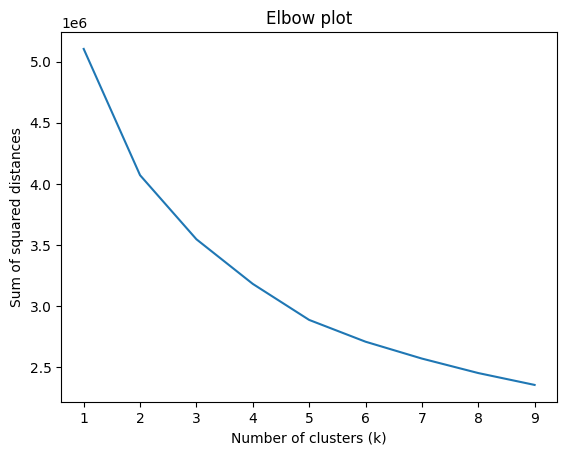

Optimal number of clusters (k): 4


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kneed import KneeLocator

embeddings = np.array(list(actorEmbedding.values()))
k_range = range(1, 10)
sse = []
for k in k_range:
    km = KMeans(n_clusters=k)
    km.fit(embeddings)
    sse.append(km.inertia_)

kneedle = KneeLocator(k_range, sse, curve='convex', direction='decreasing')
optimal_k = kneedle.elbow

plt.plot(k_range, sse)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances')
plt.title('Elbow plot')
plt.show()
print('Optimal number of clusters (k):', optimal_k)

Analysing the actor embedding, we will cluster them on their similarity 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


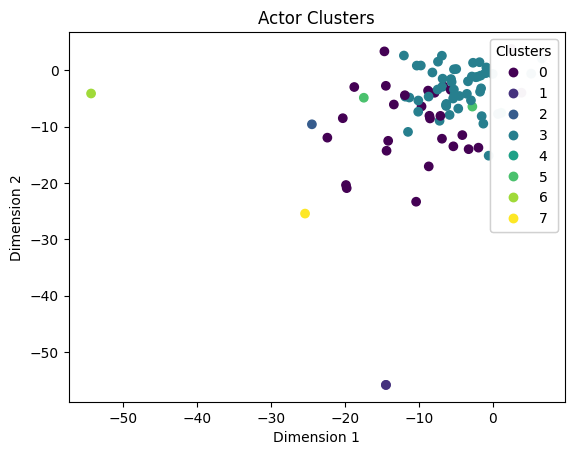

In [21]:
from scipy.spatial.distance import cdist
embeddings = np.array(list(actorEmbedding.values()))
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit(embeddings)

labels = kmeans.labels_


actor_names = list(actorEmbedding.keys())
clustered_actors = {actor_names[i]: labels[i] for i in range(len(actor_names))}


fig, ax = plt.subplots()
scatter = ax.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='viridis')

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Clusters")
ax.add_artist(legend1)

ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_title('Actor Clusters')

plt.show()


In [22]:
get_actor_embedding_df['actor_cluster'] = get_actor_embedding_df['actor'].map(clustered_actors)

In [23]:
get_actor_embedding_df.loc[get_actor_embedding_df['actor_cluster'] == 3, "actor"].values[0]

'RussellCrowe'

In [24]:
get_actor_embedding_df.loc[get_actor_embedding_df['actor_cluster'] == 1, "actor"].values[0]

'RobertDowneyJr.'

#### Movie Plot to Plot embedding
We will replace plot to plot embedding "numeric vector" for the purpose of training and recommendation 

In [25]:
bert_model=transformers.DistilBertModel
berttokenizer=transformers.DistilBertTokenizer
weights_type="distilbert-base-uncased"

In [26]:
tokenizer=berttokenizer.from_pretrained(weights_type)
model=bert_model.from_pretrained(weights_type)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
finaldata = get_plot_embedding_df[["title","plot"]]
finaldata = finaldata.set_index('title')

In [28]:
finaldata.head()

,plot
title,
Clean,"Clean is a garbage man, attempting a quiet lif..."
Unhinged,Academy Award winner Russell Crowe stars in Un...
Knight and Day,Looking forward to attending her sister April'...
Jolt,A bouncer with a slightly murderous anger-mana...
Gemini Man,"Retiring assassin, Henry Brogan finds himself ..."


In [29]:
inputs = finaldata["plot"].apply((lambda plot: tokenizer.encode(plot, add_special_tokens=True,max_length=100,truncation=True)))

In [30]:
print(inputs[0])

[101, 4550, 2003, 1037, 13044, 2158, 1010, 7161, 1037, 4251, 2166, 1997, 18434, 1010, 2066, 17738, 26477, 2010, 2451, 1005, 1055, 29283, 5014, 1012, 2002, 2003, 11587, 2011, 1037, 6355, 2627, 1998, 1996, 3279, 1997, 2010, 2684, 1012, 2043, 1037, 28616, 3270, 2361, 3084, 2032, 1996, 4539, 1997, 1037, 4126, 5795, 1010, 4550, 2003, 3140, 2000, 2272, 2000, 3408, 2007, 2010, 2627, 2004, 1996, 4808, 1997, 2010, 3025, 2166, 2003, 3254, 9105, 2039, 2007, 2032, 1012, 102]


In [31]:
import numpy as np
def padding(list_of_sent):
  output=[]
  max_len=100
  for sent in list_of_sent.values:
    padded_sent=sent+[0]*(max_len-len(sent))
    output.append(padded_sent)
  output=np.array(output)
  return output

In [32]:
inputs=padding(inputs)

In [33]:
print(inputs[0])

[  101  4550  2003  1037 13044  2158  1010  7161  1037  4251  2166  1997
 18434  1010  2066 17738 26477  2010  2451  1005  1055 29283  5014  1012
  2002  2003 11587  2011  1037  6355  2627  1998  1996  3279  1997  2010
  2684  1012  2043  1037 28616  3270  2361  3084  2032  1996  4539  1997
  1037  4126  5795  1010  4550  2003  3140  2000  2272  2000  3408  2007
  2010  2627  2004  1996  4808  1997  2010  3025  2166  2003  3254  9105
  2039  2007  2032  1012   102     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]


In [34]:
mask=np.where(inputs!=0,1,0)
embedded_inputs = torch.tensor(inputs)
attention_mask = torch.tensor(mask)

In [35]:
with torch.no_grad():
  final_states = model(embedded_inputs, attention_mask=attention_mask)

In [36]:
extracted_features=final_states[0][:,0,:].numpy()

In [37]:
cos_sim=cosine_similarity(extracted_features,extracted_features)

In [38]:
indices=pd.Series(finaldata.index)

In [39]:
indices

0                                 Clean
1                              Unhinged
2                        Knight and Day
3                                  Jolt
4                            Gemini Man
                     ...               
1667    Three Thousand Years of Longing
1668        Buttons, A New Musical Film
1669                   Dear Evan Hansen
1670                       Palm Springs
1671                   The Tomorrow War
Name: title, Length: 1672, dtype: object

In [40]:
def similar_movies(title, cosine_sim = cos_sim):
    recommended_movies = []
    index = indices[indices == title].index[0]
    similarity_scores = pd.Series(cosine_sim[index]).sort_values(ascending = False)
    top_10_movies = list(similarity_scores.iloc[1:16].index)
    for i in top_10_movies:
        recommended_movies.append(list(finaldata.index)[i])
    return recommended_movies

In [41]:
similar_movies("Extraction")

['Spiral',
 'Oldboy',
 'Father of Invention',
 'Wanted',
 "Hitman's Wife's Bodyguard",
 'Red Notice',
 'Dying of the Light',
 'Army of Thieves',
 'The Gambler',
 'A Scanner Darkly',
 'John Wick: Chapter 3 - Parabellum',
 'Collateral Damage',
 'Army of One',
 'Imperium',
 'Vigilante']

### Calculating the Actor Rating
For a given actor the actor rating is the average of all the movie's ratings that the actor has worked in. 

In [42]:
all_actors = set(get_actor_rating_df['actor'])
actor_to_rating_map = {}

for actor_name in all_actors:
    filtered_df = get_actor_rating_df[get_actor_rating_df['actor'] == actor_name]
    avg_rating = round(filtered_df['imdb'].mean(), 2)
    actor_to_rating_map[actor_name] = avg_rating

print("Total Unique Unique Actors: ",len(actor_to_rating_map.keys()))
print(actor_to_rating_map)

Total Unique Unique Actors:  86
{'NicoleKidman': 6.52, 'BrendanFraser': 5.6, 'KateWinslet': 6.55, 'TomCruise': 6.98, 'ChrisHemsworth': 6.28, 'WoodyHarrelson': 6.55, 'MorganFreeman': 6.2, 'EthanHawke': 6.44, 'JeremyRenner': 6.26, 'TildaSwinton': 6.67, 'JackNicholson': 6.86, 'LeonardoDiCaprio': 7.64, 'ZooeyDeschanel': 6.48, 'J.K.Simmons': 6.33, 'AnthonyHopkins': 6.2, 'AlPacino': 5.96, 'KevinHart': 6.0, 'ScarlettJohansson': 6.64, 'DanielRadcliffe': 7.13, 'JakeGyllenhaal': 7.01, 'WillSmith': 6.66, 'BillMurray': 6.3, 'MichaelCaine': 6.58, 'EmmaWatson': 6.63, 'RussellCrowe': 6.65, 'JuliaRoberts': 6.3, 'AndrewGarfield': 7.11, 'MatthewMcConaughey': 6.52, 'NathalieEmmanuel': 5.85, 'BenAffleck': 6.3, 'EvaGreen': 6.38, 'JimCarrey': 6.5, 'RobertDowneyJr.': 7.0, 'TomHanks': 7.05, 'MarkRuffalo': 6.49, 'RobinWilliams': 5.94, 'LaurenceFishburne': 5.98, 'EdwardNorton': 6.88, 'IanMcKellen': 7.16, 'ReeseWitherspoon': 6.12, 'HughJackman': 6.72, 'EmilyBlunt': 6.6, 'EmmaStone': 6.6, 'JoaquinPhoenix': 6.83, 

### Final Actor Recommendation Function

In [63]:
def actor_recommendations(title, cosine_sim = cos_sim):
    recommended_ind = []
    index = indices[indices == title].index[0]
    similarity_scores = pd.Series(cosine_sim[index]).sort_values(ascending = False)
    top_10_movies = list(similarity_scores.iloc[1:10].index)
    req = list()

    count = 0
    for i in top_10_movies:
      recommended_ind.append(i)
      if df.iloc[i]["actor"] not in req:
        req.append(df.iloc[i]["actor"])
        count += 1
      if count == 10:
        break;
    
    req = list(set(req))
    sorted_actors = sorted(req, key=lambda x: list(clustered_actors.values()).count(clustered_actors[x]), reverse=True)
    sorted_list = sorted(sorted_actors, key=lambda x: actor_to_rating_map[x])

    # print(sorted_list)

    return sorted_list
    # return req

In [44]:
print(actor_recommendations("Thor"))


['ArnoldSchwarzenegger', 'GalGadot', 'ChrisHemsworth', 'J.K.Simmons', 'VinDiesel', 'JohnnyDepp', 'SteveCarell', 'ChristianBale', 'DanielRadcliffe', 'RyanGosling']


In [45]:
actor_recommendations("The Hunger Games: Catching Fire")

['BrendanFraser',
 'JamesFranco',
 'DwayneJohnson',
 'KeanuReeves',
 'JackBlack',
 'JenniferLawrence',
 'RussellCrowe',
 'HughJackman',
 'JoaquinPhoenix',
 'ChristianBale']

In [46]:
actor_recommendations("Clean")

['NicolasCage',
 'JamesFranco',
 'KevinHart',
 'DwayneJohnson',
 'AdrienBrody',
 'BillMurray',
 'JesseEisenberg',
 'KevinSpacey',
 'JohnnyDepp',
 'ChristianBale']

In [47]:
actor_recommendations("Chef")

['NicolasCage',
 'AlPacino',
 'DwayneJohnson',
 'BillMurray',
 'J.K.Simmons',
 'JimCarrey',
 'ScarlettJohansson',
 'SteveCarell',
 'EdHarris',
 'MattDamon']

In [48]:
actor_recommendations("Babylon")

['SandraBullock',
 'AngelinaJolie',
 'KateWinslet',
 'EmmaStone',
 'DonCheadle',
 'CateBlanchett',
 'ChristianBale',
 'TomHanks',
 'BradPitt',
 'RyanGosling']

In [49]:
actor_recommendations("Zeros and Ones")

['MargotRobbie',
 'DwayneJohnson',
 'KeanuReeves',
 'ChrisHemsworth',
 'AngelinaJolie',
 'KevinSpacey',
 'WoodyHarrelson',
 'VinDiesel',
 'WillSmith',
 'TomCruise']

In [50]:
great_movi = df[df["imdb"] > 6]
great_movi

,title,genres,plot,imdb,actor
2,Knight and Day,"Action,Adventure,Comedy",Looking forward to attending her sister April'...,6.3,TomCruise
5,The Father,"Drama,Mystery","Having just scared off his recent caregiver, A...",8.2,AnthonyHopkins
6,Amsterdam,"Comedy,Drama,History","""Amsterdam,"" the latest film from acclaimed wr...",6.1,ChristianBale
8,John Wick: Chapter 4,"Action,Crime,Thriller",Condemned by the tyrannical High Table to be o...,8.2,KeanuReeves
9,Babylon,"Comedy,Drama,History",An original epic set in 1920s Los Angeles led ...,7.2,BradPitt
...,...,...,...,...,...
1818,Eternals,"Action,Adventure,Fantasy",Following the events of Avengers: Endgame (201...,6.3,AngelinaJolie
1819,Three Thousand Years of Longing,"Drama,Fantasy,Romance",Dr Alithea Binnie (Tilda Swinton) is an academ...,6.7,TildaSwinton
1821,Dear Evan Hansen,"Drama,Musical",Film adaptation of the Tony and Grammy Award-w...,6.1,AmyAdams
1822,Palm Springs,"Comedy,Fantasy,Mystery","While stuck at a wedding in Palm Springs, Nyle...",7.4,J.K.Simmons


In [73]:
great_movi = df[df["imdb"] > 7.0]
right_count = left_count = count = 0
for title in great_movi["title"].values:
    actors = actor_recommendations(title)
    # index = indices[indices == title].index[0]
    actor_in = df.loc[df["title"] == title, "actor"].values[0]
    rating_in = df.loc[df["title"] == title, "imdb"].values[0]

    if actor_in in actors:
          left_count += 1
    count += 1
print("Total Movies with rating (> 7.0) : ", count)
print("Total Movies with rating (> 7.0) and original actor recommended: ", left_count)
print("Good Prediction Ratio: ", left_count/count)

Total Movies with rating (> 7.0) :  436
Total Movies with rating (> 7.0) and original actor recommended:  356
Good Prediction Ratio:  0.8165137614678899


In [65]:
great_movi = df[df["imdb"] < 4.0]
right_count = left_count = count = 0
for title in great_movi["title"].values:
    actors = actor_recommendations(title)
    # index = indices[indices == title].index[0]
    actor_in = df.loc[df["title"] == title, "actor"].values[0]
    rating_in = df.loc[df["title"] == title, "imdb"].values[0]
    if rating_in < 4.0:
        # print(actor_in)
        if actor_in in actors:
          left_count += 1
    count += 1

print("Total Movies with rating (< 4.0) : ", count)
print("Total Movies with rating (< 4.0) and original actor recommended: ", left_count)
print("Bad Prediction Ratio: ", left_count/count)

Total Movies with rating (< 4.0) :  21
Total Movies with rating (< 4.0) and original actor recommended:  4
Bad Prediction Ratio:  0.19047619047619047
